In [10]:
!pip install prettytable


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import torch as th
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from envs.bidding import BiddingEnv  # Assuming this is your custom environment
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
# from prettytable import PrettyTable

## Training Debugging

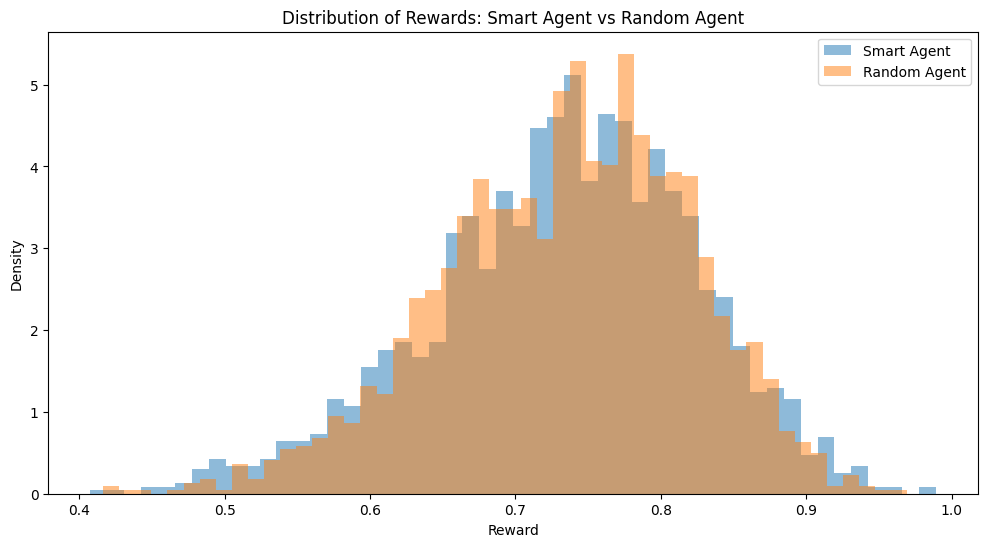

In [3]:
env = BiddingEnv()
vec_env = DummyVecEnv([lambda: env])
model = SAC.load("./runs/baselines/SAC/best_model", env=vec_env)

obs, _ = env.reset()

smart_rewards, random_rewards = [], []

num_experiments = 2000

for i in range(num_experiments):
    smart_action, _ = model.predict(obs, deterministic=True) # use pretrained model
    random_action = env.action_space.sample() # sample random action

    obs, reward, done, truncated, info = env.step(smart_action)
    smart_rewards.append(reward)

    obs, reward, done, truncated, info = env.step(random_action)
    random_rewards.append(reward)

    obs, _ = env.reset()

# plt.scatter(np.arange(num_experiments), smart_rewards, label='Smart Agent')
# plt.scatter(np.arange(num_experiments), random_rewards, label='Random Agent')
# plt.legend()
# plt.show()
plt.figure(figsize=(12, 6))
plt.hist(smart_rewards, bins=50, alpha=0.5, label='Smart Agent', density=True)
plt.hist(random_rewards, bins=50, alpha=0.5, label='Random Agent', density=True)
plt.legend()
plt.xlabel('Reward')
plt.ylabel('Density')
plt.title('Distribution of Rewards: Smart Agent vs Random Agent')
plt.show()


    

In [25]:
env.observation_space

Dict('robot_positions': Box(0, 9, (9, 2), int32), 'robot_types': Box(0, 2, (9,), int32), 'task_positions': Box(0, 9, (6, 2), int32), 'task_prizes': Box(1, 100, (6,), int32), 'task_types': Box(0, 2, (6,), int32))

## Sample Game

In [19]:
env = BiddingEnv()
obs, _ = env.reset()

env.render(mode='human_verbose')

smart_action, _ = model.predict(obs, deterministic=True) # use pretrained model
random_action = env.action_space.sample() # sample random action

print('Smart Agent Action:')
print(
    tabulate(
        np.round(smart_action, 1), 
        headers=[f"Task {i+1}" for i in range(len(smart_action))], 
        tablefmt='fancy_grid'
    )
)

print('\nRandom Agent Action:')
print(
	tabulate(
		random_action, 
		headers=[f"Task {i+1}" for i in range(len(random_action))], 
		tablefmt='fancy_grid'
	)
)

Step: 0

Robots:
  Robot 1: Robot at (9, 4) with type A-humanbot
  Robot 2: Robot at (4, 1) with type B-navbot
  Robot 3: Robot at (6, 5) with type A-humanbot
  Robot 4: Robot at (3, 6) with type B-navbot
  Robot 5: Robot at (9, 6) with type C-embedbot
  Robot 6: Robot at (4, 1) with type C-embedbot
  Robot 7: Robot at (2, 8) with type C-embedbot
  Robot 8: Robot at (6, 2) with type C-embedbot
  Robot 9: Robot at (0, 5) with type A-humanbot

Tasks:
  Task 1: Task at (9, 5) with prize 8 and type C-specialty
  Task 2: Task at (3, 6) with prize 5 and type C-specialty
  Task 3: Task at (8, 3) with prize 7 and type B-transport
  Task 4: Task at (1, 3) with prize 9 and type B-transport
  Task 5: Task at (9, 5) with prize 5 and type B-transport
  Task 6: Task at (5, 1) with prize 9 and type A-manipulation

Bidding Matrix:
╒══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│   Task 1 │   Task 2 │   Task 3 │   Task 4 │   Task 5 │   Task 6 │
╞══════════╪══════════╪══════════╪═══